# Extra convolutional layers
In this chapter we will add more convolutional layers to increase the complexity of the model. In this way the model might learn the data better.

In [ ]:
import zipfile
import os
import cv2
import pandas as pd
from os import chdir, listdir

import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing, regularizers
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from keras import backend as K
from keras import activations

# Import zip with the data
The data is imported as a zip from the github of our project group. The zip is unpacked in the google colab, so the data is accesible. 

In [ ]:
# Code from: https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e

# Get zip file from Github URL
!wget --no-check-certificate \
    "https://github.com/ilsefeenstra/Fitgirls0011/archive/refs/heads/main.zip" \
    -O "/tmp/pawpularity_data.zip"

# Opens the zip file in read mode and extract files into /tmp folder
zip_ref = zipfile.ZipFile('/tmp/pawpularity_data.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-01-26 11:43:45--  https://github.com/ilsefeenstra/Fitgirls0011/archive/refs/heads/main.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ilsefeenstra/Fitgirls0011/zip/refs/heads/main [following]
--2022-01-26 11:43:46--  https://codeload.github.com/ilsefeenstra/Fitgirls0011/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 52.68.31.213
Connecting to codeload.github.com (codeload.github.com)|52.68.31.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/pawpularity_data.zip’

/tmp/pawpularity_da     [           <=>      ] 993.57M  13.9MB/s    in 72s     

2022-01-26 11:44:58 (13.9 MB/s) - ‘/tmp/pawpularity_data.zip’ saved [1041838077]



# Import tabular data

The tabular data is imported. This contains information on whether several elements are present in the image, such as blur, a human, a group, etc. Also the pawpularity score of the training data is in the table. For the test data only the image ID and the features are in the table. There is also a sample submission table, which contains the pawpularity score for the test data.

In [ ]:
# Import the CSV tables
csv_train_data = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/train.csv")
csv_test_data = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/sample_submission.csv")
csv_train_data.head()

# Drop rows with missing values (if NaN values are in dataframe)
# No missing values present, so no samples dropped
csv_train_data.dropna()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


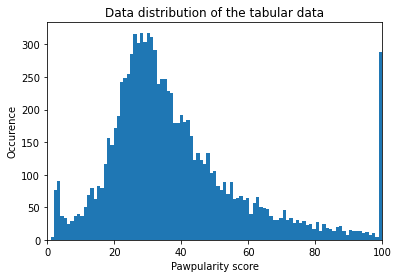

In [ ]:
# Create a plot that shows the distribution of the output of the training samples
plt.hist(csv_train_data['Pawpularity'], bins=100)
plt.title("Data distribution of the tabular data")
plt.xlabel("Pawpularity score")
plt.ylabel("Occurence")
plt.xlim(0, 100)

plt.show()

# Import image data
The images are imported from the folders. Each image is reshaped to a 64x64 image. In this way all the images have the same shape and we do not use much memory, to speed up analysis. After the images are imported, the images and their names are shuffled. This is done, so we can later take a validation sample containing a random subsample of the dataset. It could be that the images in the dataset contain some order, so by shuffling we ensure that the subset for the validation data is random.


In [ ]:
def reshape_images(path, n):
    """
    This function returns a list of images, which are reshaped to 64 x 64 
    and a list with the names of the images.
    """
    # Set the current path
    chdir(path)
    
    # Preset the lists
    images = []
    image_names = []
    
    # Go over all the files in the path
    for i in listdir():
        
        # Get the name of the image, without .jpg
        image_names.append(i[:-4])
        
        # Get the image and reshape to n x n
        file = cv2.imread(i)
        file = cv2.resize(file,(n, n), interpolation=cv2.INTER_AREA)
        
        # Rescale the pixels and store in the list
        images.append(file/255)
        
    return images, image_names

# Reshape train and test images
train_imgs, train_names = reshape_images("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/train", 64)
test_imgs, test_names = reshape_images("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/test", 64)

# Combine tabular data with images
To ensure that the dataframe has the same order as the images in the list, we sort the dataframe based on the names of the images. If this would not be the case, it could be that you learn incorrectly, as the output of an image perhaps is not the real output.

In [ ]:
def sort_dataframe(data, images, names):
    """
    This function sorts the dataframe of the csv data according to the image names.
    """
    data_sorted = pd.DataFrame()

    # Iterate over images and get index of each image
    for img, name in zip(images, names):
        location = data[data['Id'] == name].index[0]

        # Sort dataframe according to index of images
        data_sorted = data_sorted.append([data.loc[location]])

        # Reset the index of the dataframe
        data_sorted = data_sorted.reset_index().drop(['index'],axis=1)
        
    return data_sorted

# Sort training and testing data
train_data_sorted = sort_dataframe(csv_train_data, train_imgs, train_names)
test_data_sorted = sort_dataframe(csv_test_data, test_imgs, test_names)
sample_submission_sorted = sort_dataframe(sample_submission, test_imgs, test_names)

# Processing data
The tabular data is split in x and y values and converted to numpy arrays, so the neural network can handle the data. Moreover, the image data is converted to numpy arrays.

In [ ]:
# Remove samples with pawpularity score of 100
indexNames = train_data_sorted[train_data_sorted['Pawpularity'] == 100].index
train_data_new = train_data_sorted.drop(indexNames)
train_imgs_new = np.delete(train_imgs, indexNames, axis=0)

In [ ]:
# Select x-values (the 12 input features) and y-values from training data
x_tabular = train_data_new.iloc[:,1:13].to_numpy()
y = train_data_new.iloc[:,13].to_numpy()

# Select x (the 12 input features) and y (pawpularity) values from testing data
x_test_tabular = test_data_sorted.iloc[:,1:13].to_numpy()
y_test = sample_submission_sorted.iloc[:,1].to_numpy()

# Create numpy array of image data 
x_images = np.array(train_imgs_new)
test_imgs_array = np.array(test_imgs)

# Create seperate neural networks
We create a tabular neural network to handle the data in the csv. Then we create a convolutional neural network to handle the image data. Both neural networks have no output layer, since they will be concatenated to one neural network, which will give the output.

In [ ]:
def build_neural_net(input_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number of 
    hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()

    # Create hidden layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu', input_shape=(input_size,)))    

    # Create hidden layer with relu activations
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(units=hidden_nodes, activation="relu"))

    # Create hidden layer with relu activations
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(units=hidden_nodes, activation="relu"))

    return model

In [ ]:
def build_convol_net(image_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number 
    of hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()
    
    # Create a convolutional layer with relu activation
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=image_size, padding='same'))
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=image_size, padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    model.add(layers.BatchNormalization())

    # Create a convolutional layer with relu activation
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    model.add(layers.BatchNormalization())

    # Create a convolutional layer with relu activation
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    model.add(layers.BatchNormalization())
    
    # Create a flattening layer
    model.add(layers.Flatten())

    # Create a dense layer with relu activations
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=hidden_nodes, activation="relu", 
              kernel_regularizer=regularizers.l2(1e-3),
              bias_regularizer=regularizers.l2(1e-3),
              activity_regularizer=regularizers.l2(1e-3)))

    # Create a dense layer with relu activations
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=hidden_nodes, activation="relu", 
              kernel_regularizer=regularizers.l2(1e-3),
              bias_regularizer=regularizers.l2(1e-3),
              activity_regularizer=regularizers.l2(1e-3)))
    
    return model

## Concatenate tabular and image data models
Concatenate the tabular and image models to create one neural network that can handle both types of data. This neural network will give the prediction of the pawpularity.

In [ ]:
def linear_limit(x):
    """
    Create a linear activation function that clips the output at 0 and 100.
    """
    activation_x = activations.linear(x)
    activation_x_new = K.clip(activation_x, 0, 100)

    return activation_x_new

In [ ]:
def concatenate_models(model1, model2, hidden_nodes):
    """
    Concatenate two neural network models, model1 and model2, and create
    a concatenated model with dense layers with some hidden nodes.
    """
    # Input for concatenated model is retrieved by concatenating the output
    # of both models
    concat_input = layers.concatenate([model1.output, model2.output])

    # Create hidden layer with relu activation
    hidden_layer_1 = layers.Dense(hidden_nodes, activation="relu", 
              kernel_regularizer=regularizers.l2(1e-1),
              bias_regularizer=regularizers.l2(1e-1),
              activity_regularizer=regularizers.l2(1e-1))(concat_input)

    # Create hidden layer with relu activation
    drop_out_1 = layers.Dropout(0.4)(hidden_layer_1)    
    hidden_layer_2 = layers.Dense(hidden_nodes, activation="relu", 
              kernel_regularizer=regularizers.l2(1e-1),
              bias_regularizer=regularizers.l2(1e-1),
              activity_regularizer=regularizers.l2(1e-1))(drop_out_1)

    # Create hidden layer with relu activation
    drop_out_2 = layers.Dropout(0.4)(hidden_layer_2)
    hidden_layer_3 = layers.Dense(hidden_nodes, activation="relu", 
              kernel_regularizer=regularizers.l2(1e-1),
              bias_regularizer=regularizers.l2(1e-1),
              activity_regularizer=regularizers.l2(1e-1))(drop_out_2)

    # Create output layer
    output_layer = layers.Dense(1, activation=linear_limit)(hidden_layer_3)

    # Create concatenated model with inputs of both models and output of the
    # concatenated model
    concat_model = models.Model(inputs=[model1.input, model2.input], outputs=output_layer)

    return concat_model

In [ ]:
def train_and_evaluate(model, image_x, tabular_x, train_y, x_val_tabular, x_val_imgs, val_y, epochs=20, preprocess = {}, augment={}):
    """
    This function trains and evaluated a model. It first compiles the model with 
    the loss and metrics. It then makes a train and validation generator for the 
    image data, based on the preprocess and augment input. 
    It then trains the model on both the image and tabular data for epochs times. 
    The values of the loss and metric are plotted and printed.
    """
    # Compile model and use mean squared error as loss and root mean squared error as metric
    model.compile(loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

    # Preprocess the image data
    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(image_x)

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(image_x)

    # Train the model by fitting both tabular and image data at the same time
    history = model.fit(train_gen.flow([image_x, tabular_x], train_y), epochs = epochs, validation_data=val_gen.flow([x_val_imgs, x_val_tabular], val_y))

    return history

Epoch 1/60
241/241 [==============================] - 33s 86ms/step - loss: 814.3018 - root_mean_squared_error: 25.8086 - val_loss: 1271.9137 - val_root_mean_squared_error: 29.2493
Epoch 2/60
241/241 [==============================] - 19s 80ms/step - loss: 570.0753 - root_mean_squared_error: 22.0463 - val_loss: 480.3073 - val_root_mean_squared_error: 20.8787
Epoch 3/60
241/241 [==============================] - 19s 80ms/step - loss: 503.6988 - root_mean_squared_error: 21.1669 - val_loss: 473.6374 - val_root_mean_squared_error: 21.1085
Epoch 4/60
241/241 [==============================] - 19s 81ms/step - loss: 441.3715 - root_mean_squared_error: 20.0527 - val_loss: 391.7316 - val_root_mean_squared_error: 19.1572
Epoch 5/60
241/241 [==============================] - 19s 80ms/step - loss: 413.0374 - root_mean_squared_error: 19.5983 - val_loss: 356.2947 - val_root_mean_squared_error: 18.3086
Epoch 6/60
241/241 [==============================] - 19s 80ms/step - loss: 382.3186 - root_mean_sq

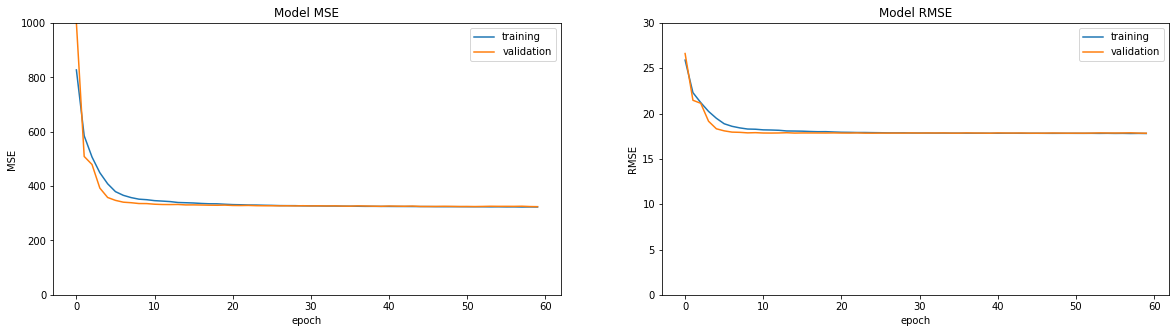

In [ ]:
from sklearn.model_selection import KFold

def k_fold(num_folds, x_tabular, y, x_imgs, epochs=20, preprocess={}, augment={}):
    """
    Train and evaluate the data for num-folds times, and return the average 
    training and validation loss. First the data is split in num-folds batches
    and then the model is trained on the data, where a different batch is the 
    validation data each time.
    """
    # Create kfold object to later split the data
    kfold = KFold(n_splits=num_folds, shuffle=True)
    x_indices = np.array(range(len(x_tabular)))
    y_indices = np.array(range(len(y)))

    # Pre allocate variables to store the MSE (loss) and RMSE (accuracy)
    train_loss = np.array(np.zeros(epochs))
    train_acc = np.array(np.zeros(epochs))
    val_loss = np.array(np.zeros(epochs))
    val_acc = np.array(np.zeros(epochs))
    
    # Train and evaluate the model for num-fold times on a different training 
    # and validation set each time
    for id_train, id_val in kfold.split(x_indices, y_indices):
        
        # Make Neural Networks before concatenation
        tabular_NN = build_neural_net(12, hidden_nodes=20)
        image_size = (64, 64, 3)
        image_NN = build_convol_net(image_size, hidden_nodes=20)

        # Create subset training and validation data
        x_tabular_train = x_tabular[id_train]
        x_imgs_train = x_imgs[id_train]
        y_train = y[id_train]
        
        x_tabular_val = x_tabular[id_val]
        x_imgs_val = x_imgs[id_val]
        y_val_2 = y[id_val]
        
        # Train and evaluate the model
        concat_model = concatenate_models(image_NN, tabular_NN, hidden_nodes=20)
        history = train_and_evaluate(concat_model, x_imgs_train, x_tabular_train, 
                           y_train, x_tabular_val, x_imgs_val, y_val_2, epochs=epochs, preprocess=preprocess, augment=augment)

        # Add all the losses and metrics
        train_loss += history.history['loss']
        train_acc += history.history['root_mean_squared_error']
        val_loss += history.history['val_loss']
        val_acc += history.history['val_root_mean_squared_error']

    # Calculate average loss and metric
    avg_train_loss = train_loss / num_folds
    avg_val_loss = val_loss / num_folds
    avg_train_acc = train_acc / num_folds
    avg_val_acc = val_acc / num_folds

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    # Plot MSE
    axs[0].plot(avg_train_loss)
    axs[0].plot(avg_val_loss)
    axs[0].legend(['training', 'validation'], loc='best')
    
    axs[0].set_title('Model MSE')
    axs[0].set_ylabel('MSE')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylim([0, 1000])

    # Plot RMSE
    axs[1].plot(avg_train_acc)
    axs[1].plot(avg_val_acc)
    axs[1].legend(['training', 'validation'], loc='best')
    
    axs[1].set_title('Model RMSE')
    axs[1].set_ylabel('RMSE')
    axs[1].set_xlabel('epoch')
    axs[1].set_ylim([0, 30])

    plt.show()

    return avg_train_loss[-1], avg_val_loss[-1], avg_train_acc[-1], avg_val_acc[-1]

# Use k-fold cross-validation to train and evaluate concatenated network
avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc = k_fold(5, x_tabular, y, x_images, epochs=60, 
                                               preprocess={'featurewise_center': True, 'featurewise_std_normalization': True},
                                               augment={'rotation_range': 90, 'horizontal_flip': True, 'shear_range': 0.2})

print(f'The train MSE is {avg_train_loss}')
print(f'The train RMSE is {avg_train_acc}')
print(f'The validation MSE is {avg_val_loss}')
print(f'The validation RMSE is {avg_val_acc}')


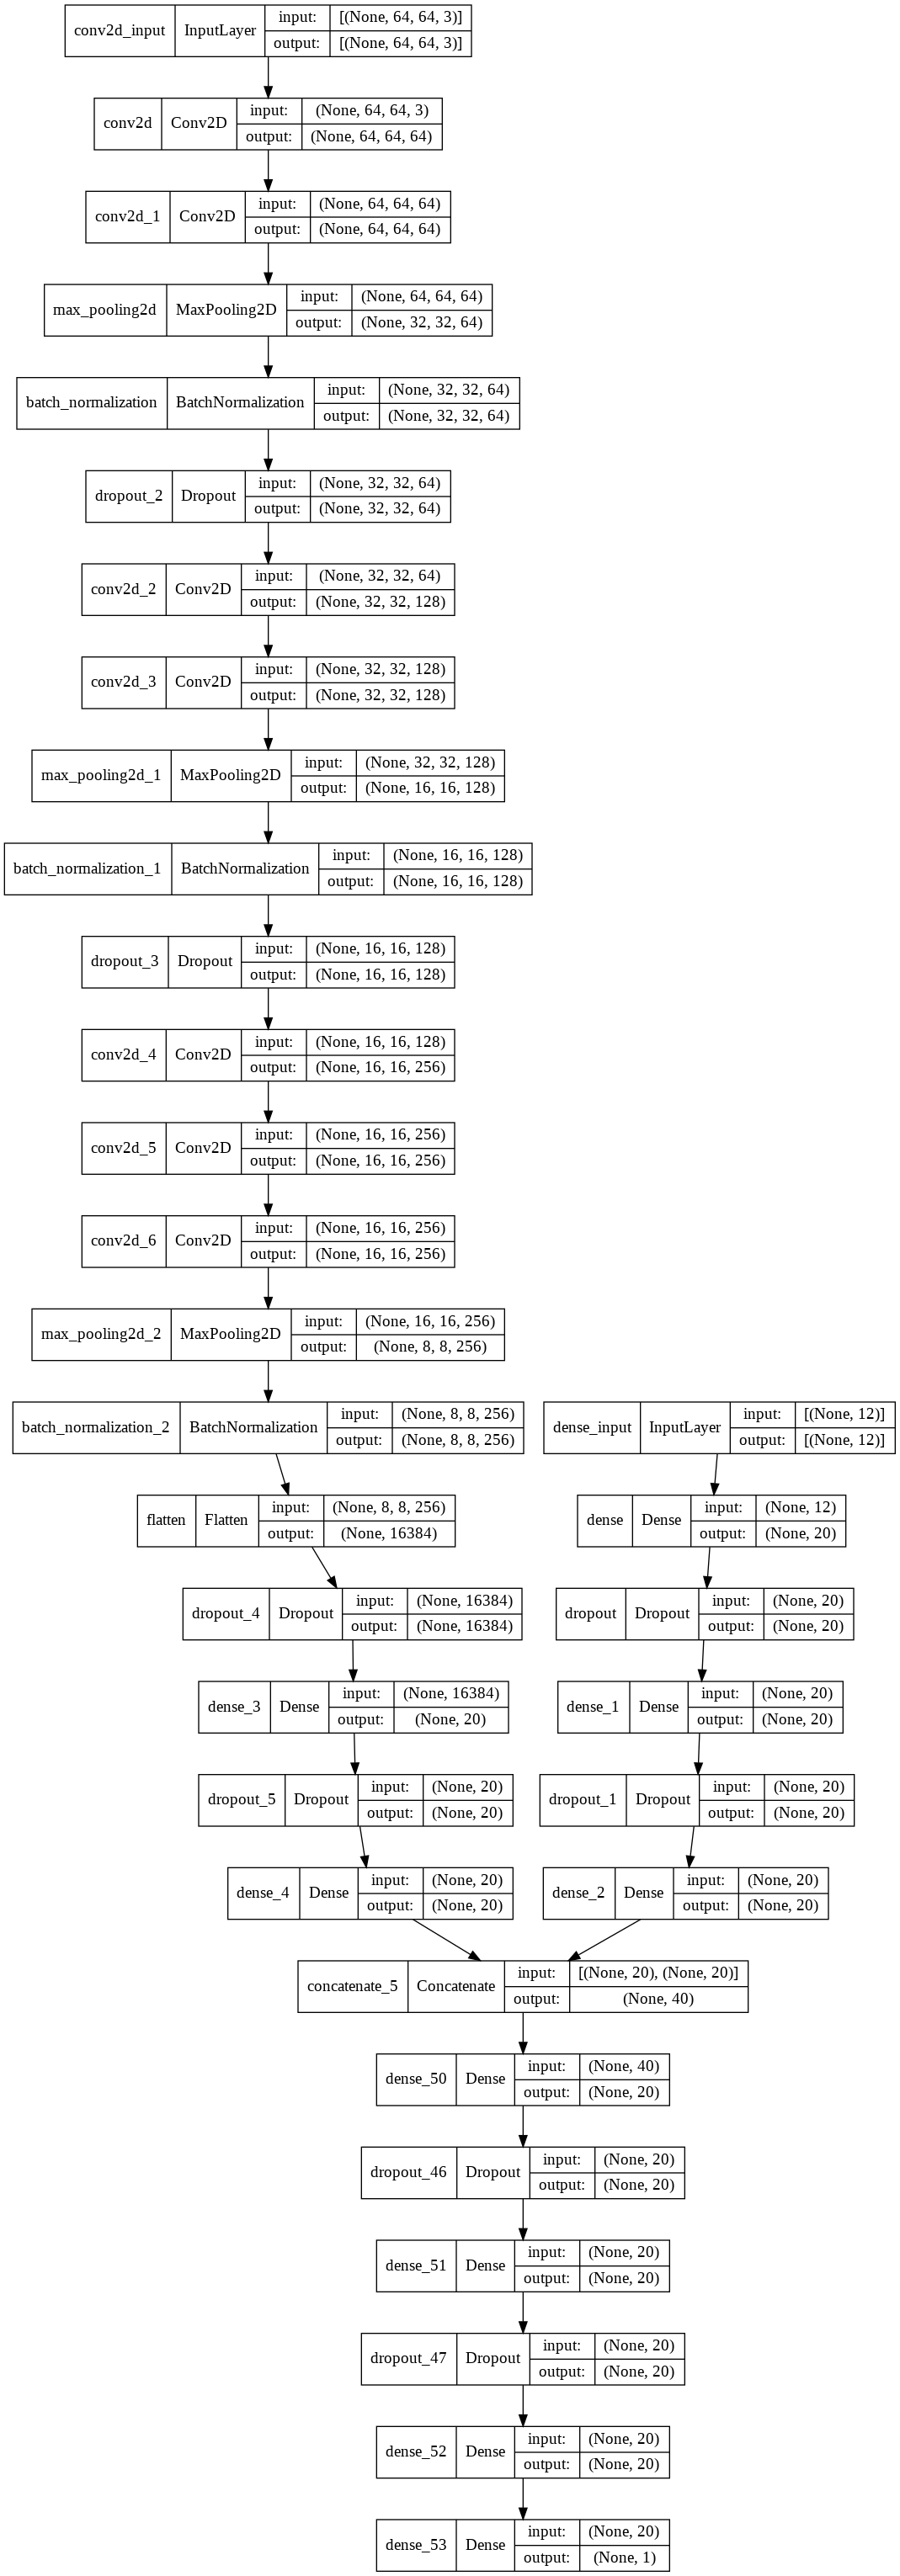

In [ ]:
# Create overview of layers in model
tf.keras.utils.plot_model(concatenate_models(image_NN, tabular_NN, hidden_nodes=20), to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
# train_loss = np.array(np.zeros(2))
# train_val = np.array(np.zeros(2))
# test_loss = np.array(np.zeros(2))
# test_val = np.array(np.zeros(2))

# for epoch in loss_df.items():
#   train_loss += epoch[1]['loss']
#   train_val += epoch[1]['root_mean_squared_error']
#   test_loss += epoch[1]['val_loss']
#   test_val += epoch[1]['val_root_mean_squared_error']

# display(test_val)